# GCN - LSTM - News Sentiment on 29 companies from DJIA Index - 200 Epochs
Student Name: Girija Madireddy                        
Student id: x21235929                                
Master of Science in Data Analytics

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

import warnings
warnings.simplefilter("ignore")

In [2]:
#import nltk
#nltk.download('vader_lexicon')

In [3]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Load news data
news_df = pd.read_csv('RedditNews.csv')



In [4]:
import re

def clean_text(text):
    """
    Function to clean the news text.
    - Lowercases the text.
    - Removes special characters and numbers.
    - Strips extra spaces.
    """
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the 'News' column
news_df['cleaned_news'] = news_df['News'].apply(clean_text)

# Display the first few rows of the dataframe after cleaning
news_df.head()


,Date,News,cleaned_news
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,a yearold woman in mexico city finally receive...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,imf chief backs athens as permanent olympic host
2,2016-07-01,"The president of France says if Brexit won, so...",the president of france says if brexit won so ...
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,british man who must give police hours notice ...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,nobel laureates urge greenpeace to stop opposi...


In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for the cleaned news
news_df['sentiment_score'] = news_df['cleaned_news'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Aggregate these scores by date
sentiment_by_date = news_df.groupby('Date')['sentiment_score'].mean().reset_index()

# Display the aggregated sentiment scores by date
sentiment_by_date.head()


,Date,sentiment_score
0,2008-06-08,-0.334284
1,2008-06-09,-0.276144
2,2008-06-10,-0.308360
3,2008-06-11,-0.130976
4,2008-06-12,-0.106308


In [6]:
# Print minimum and maximum dates
min_date = sentiment_by_date['Date'].min()
max_date = sentiment_by_date['Date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2008-06-08
Maximum date: 2016-07-01


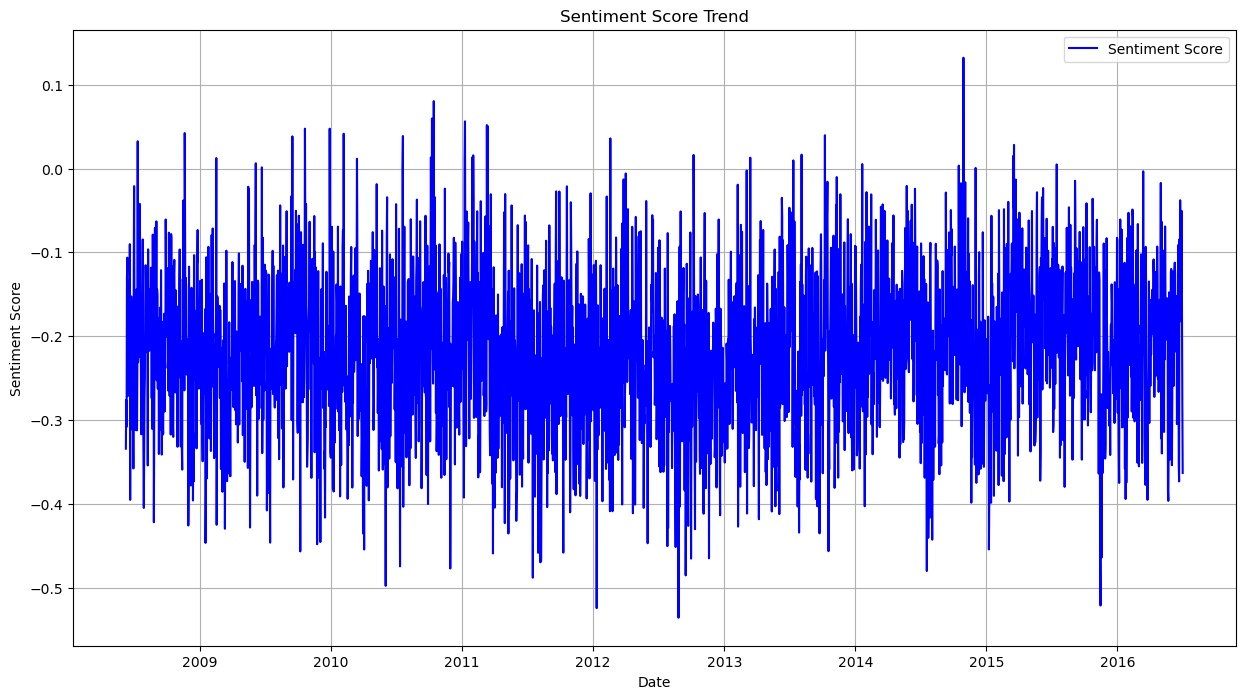

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' to datetime for proper plotting
sentiment_by_date['Date'] = pd.to_datetime(sentiment_by_date['Date'])

# Plotting the sentiment scores over time
plt.figure(figsize=(15, 8))
plt.plot(sentiment_by_date['Date'], sentiment_by_date['sentiment_score'], label='Sentiment Score', color='blue')
plt.title('Sentiment Score Trend')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
start_date = '2012-01-01'
end_date = '2014-07-01'

filtered_sentiment_data = sentiment_by_date[(sentiment_by_date['Date'] >= start_date) & (sentiment_by_date['Date'] <= end_date)]


In [9]:
# Print minimum and maximum dates
min_date_new = filtered_sentiment_data['Date'].min()
max_date_new = filtered_sentiment_data['Date'].max()

print(f"Minimum date: {min_date_new}")
print(f"Maximum date: {max_date_new}")

Minimum date: 2012-01-01 00:00:00
Maximum date: 2014-07-01 00:00:00


In [10]:
# Downloading stock data
tickers = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']
data = {ticker: yf.download(ticker, start="2012-01-01", end="2014-07-01") for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [11]:
for ticker, df in data.items():
    print(f"First 5 records for {ticker}:")
    print(df.head(), "\n")  # Prints the first 5 rows of the DataFrame


First 5 records for CSCO:
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  18.549999  18.860001  18.480000  18.629999  13.024628  41236600
2012-01-04  18.440001  19.000000  18.350000  18.990000  13.276309  52927700
2012-01-05  18.930000  19.000000  18.670000  18.920000  13.227371  37865300
2012-01-06  18.950001  19.000000  18.830000  18.850000  13.178432  27796900
2012-01-09  18.870001  19.100000  18.790001  18.969999  13.262328  37811500 

First 5 records for TRV:
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-01-03  60.110001  60.320000  58.980000  58.990002  44.468452  3522500
2012-01-04  58.840000  59.070000  58.139999  58.750000  44.287544  3934500
2012-01-05  58.360001  59.360001  58.080002  59.330002  44.724751  4748600
2012-01-06  59.570000  59.730000  59.110

In [12]:
for ticker, df in data.items():
    num_records = df.shape[0]  # Number of rows in the DataFrame
    print(f"{ticker} has {num_records} records")


CSCO has 626 records
TRV has 626 records
IBM has 626 records
PFE has 626 records
JNJ has 626 records
AXP has 626 records
GS has 626 records
GOOGL has 626 records
GE has 626 records
KO has 626 records
VZ has 626 records
BA has 626 records
NKE has 626 records
CVX has 626 records
AMZN has 626 records
UNH has 626 records
WMT has 626 records
MMM has 626 records
JPM has 626 records
DIS has 626 records
MCD has 626 records
CAT has 626 records
MRK has 626 records
XOM has 626 records
MSFT has 626 records
HD has 626 records
INTC has 626 records
PG has 626 records
AAPL has 626 records


In [13]:
# Convert 'Date' to datetime format
filtered_sentiment_data['Date'] = pd.to_datetime(filtered_sentiment_data['Date'])

# Convert Date to string for easy mapping
filtered_sentiment_data['Date'] = filtered_sentiment_data['Date'].dt.strftime('%Y-%m-%d')

# Create a dictionary for fast lookup
sentiment_dict = dict(zip(filtered_sentiment_data['Date'], filtered_sentiment_data['sentiment_score']))

# Integrate sentiment scores with stock data
for ticker, df in data.items():
    # The index of the stock DataFrame might be in a different format, ensure it's a string
    df_index_as_str = df.index.strftime('%Y-%m-%d')

    # Map sentiment scores to each date in the stock DataFrame
    df['Sentiment'] = df_index_as_str.map(sentiment_dict)

    # Handle missing sentiment values (if any)
    df['Sentiment'].fillna(0, inplace=True)


In [14]:

# Preprocessing
features = []
labels = []
for ticker, df in data.items():
    # Normalize close prices
    normalized_close = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())

    # Map sentiment scores to the stock data dates
    df_index_as_str = df.index.strftime('%Y-%m-%d')
    df['Sentiment'] = df_index_as_str.map(sentiment_dict)

    # Normalize sentiment scores 
    normalized_sentiment = (df['Sentiment'] - df['Sentiment'].min()) / (df['Sentiment'].max() - df['Sentiment'].min())

    # Combine normalized close prices and sentiment scores
    combined_features = np.column_stack((normalized_close, normalized_sentiment))

    # Append to features list
    features.append(combined_features)

    # Generate labels (1 if price increase, 0 otherwise)
    labels.append(df['Close'].diff().apply(lambda x: 1 if x > 0 else 0).values)

# Convert to numpy array
features = np.array(features)
labels = np.array(labels)

# Print shapes for verification
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)


Shape of features: (29, 626, 2)
Shape of labels: (29, 626)


In [15]:
# list of tickers corresponding to the rows in 'features'
tickers = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']

# Print the feature values for the first few records of each stock
for ticker, feature_values in zip(tickers, features):
    print(f"{ticker}: {feature_values[:5]}")  


CSCO: [[0.31172287 0.72532441]
 [0.34369451 0.62723864]
 [0.33747784 0.36124478]
 [0.33126117 0.26904841]
 [0.34191827 0.7345235 ]]
TRV: [[0.054738   0.72532441]
 [0.04854121 0.62723864]
 [0.06351673 0.36124478]
 [0.06403304 0.26904841]
 [0.07281177 0.7345235 ]]
IBM: [[0.31395347 0.72532441]
 [0.29627904 0.62723864]
 [0.2758141  0.36124478]
 [0.22651152 0.26904841]
 [0.20441859 0.7345235 ]]
PFE: [[0.08644077 0.72532441]
 [0.06949168 0.62723864]
 [0.05508483 0.36124478]
 [0.05254242 0.26904841]
 [0.07372891 0.7345235 ]]
JNJ: [[0.09322415 0.72532441]
 [0.08412925 0.62723864]
 [0.0823102  0.36124478]
 [0.06934977 0.26904841]
 [0.07162349 0.7345235 ]]
AXP: [[3.16918904e-03 7.25324413e-01]
 [0.00000000e+00 6.27238645e-01]
 [1.18317681e-02 3.61244782e-01]
 [6.33821689e-04 2.69048412e-01]
 [3.16918904e-03 7.34523497e-01]]
GS: [[0.04933802 0.72532441]
 [0.04232203 0.62723864]
 [0.04051151 0.36124478]
 [0.02738484 0.26904841]
 [0.04175628 0.7345235 ]]
GOOGL: [[0.16087848 0.72532441]
 [0.1652196

In [16]:

# List of tickers corresponding to the rows in 'features'
tickers = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']

# Function to plot scatter plots for each company
def plot_scatter(features, tickers):
    # Determine the number of rows and columns for the subplot grid
    nrows = len(tickers) // 5 + (len(tickers) % 5 > 0)
    ncols = 5
    
    # Set up the figure and axes for plotting
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))  
    axes = axes.flatten()  # Flatten the 2D axes array for easy iteration

    # Loop through each ticker and its corresponding features
    for i, (ticker, feature_values) in enumerate(zip(tickers, features)):
        # Close prices are in the first column, sentiment scores are in the second
        close_prices = feature_values[:, 0]
        sentiment_scores = feature_values[:, 1]
        
        # Create scatter plot for each company
        ax = axes[i]
        ax.scatter(close_prices, sentiment_scores, alpha=0.5)
        ax.set_title(ticker)
        ax.set_xlabel('Normalized Close Price')
        ax.set_ylabel('Normalized Sentiment Score')

        # Set limits for better comparison
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Adjust layout to prevent overlapping
    fig.tight_layout()
    plt.show()



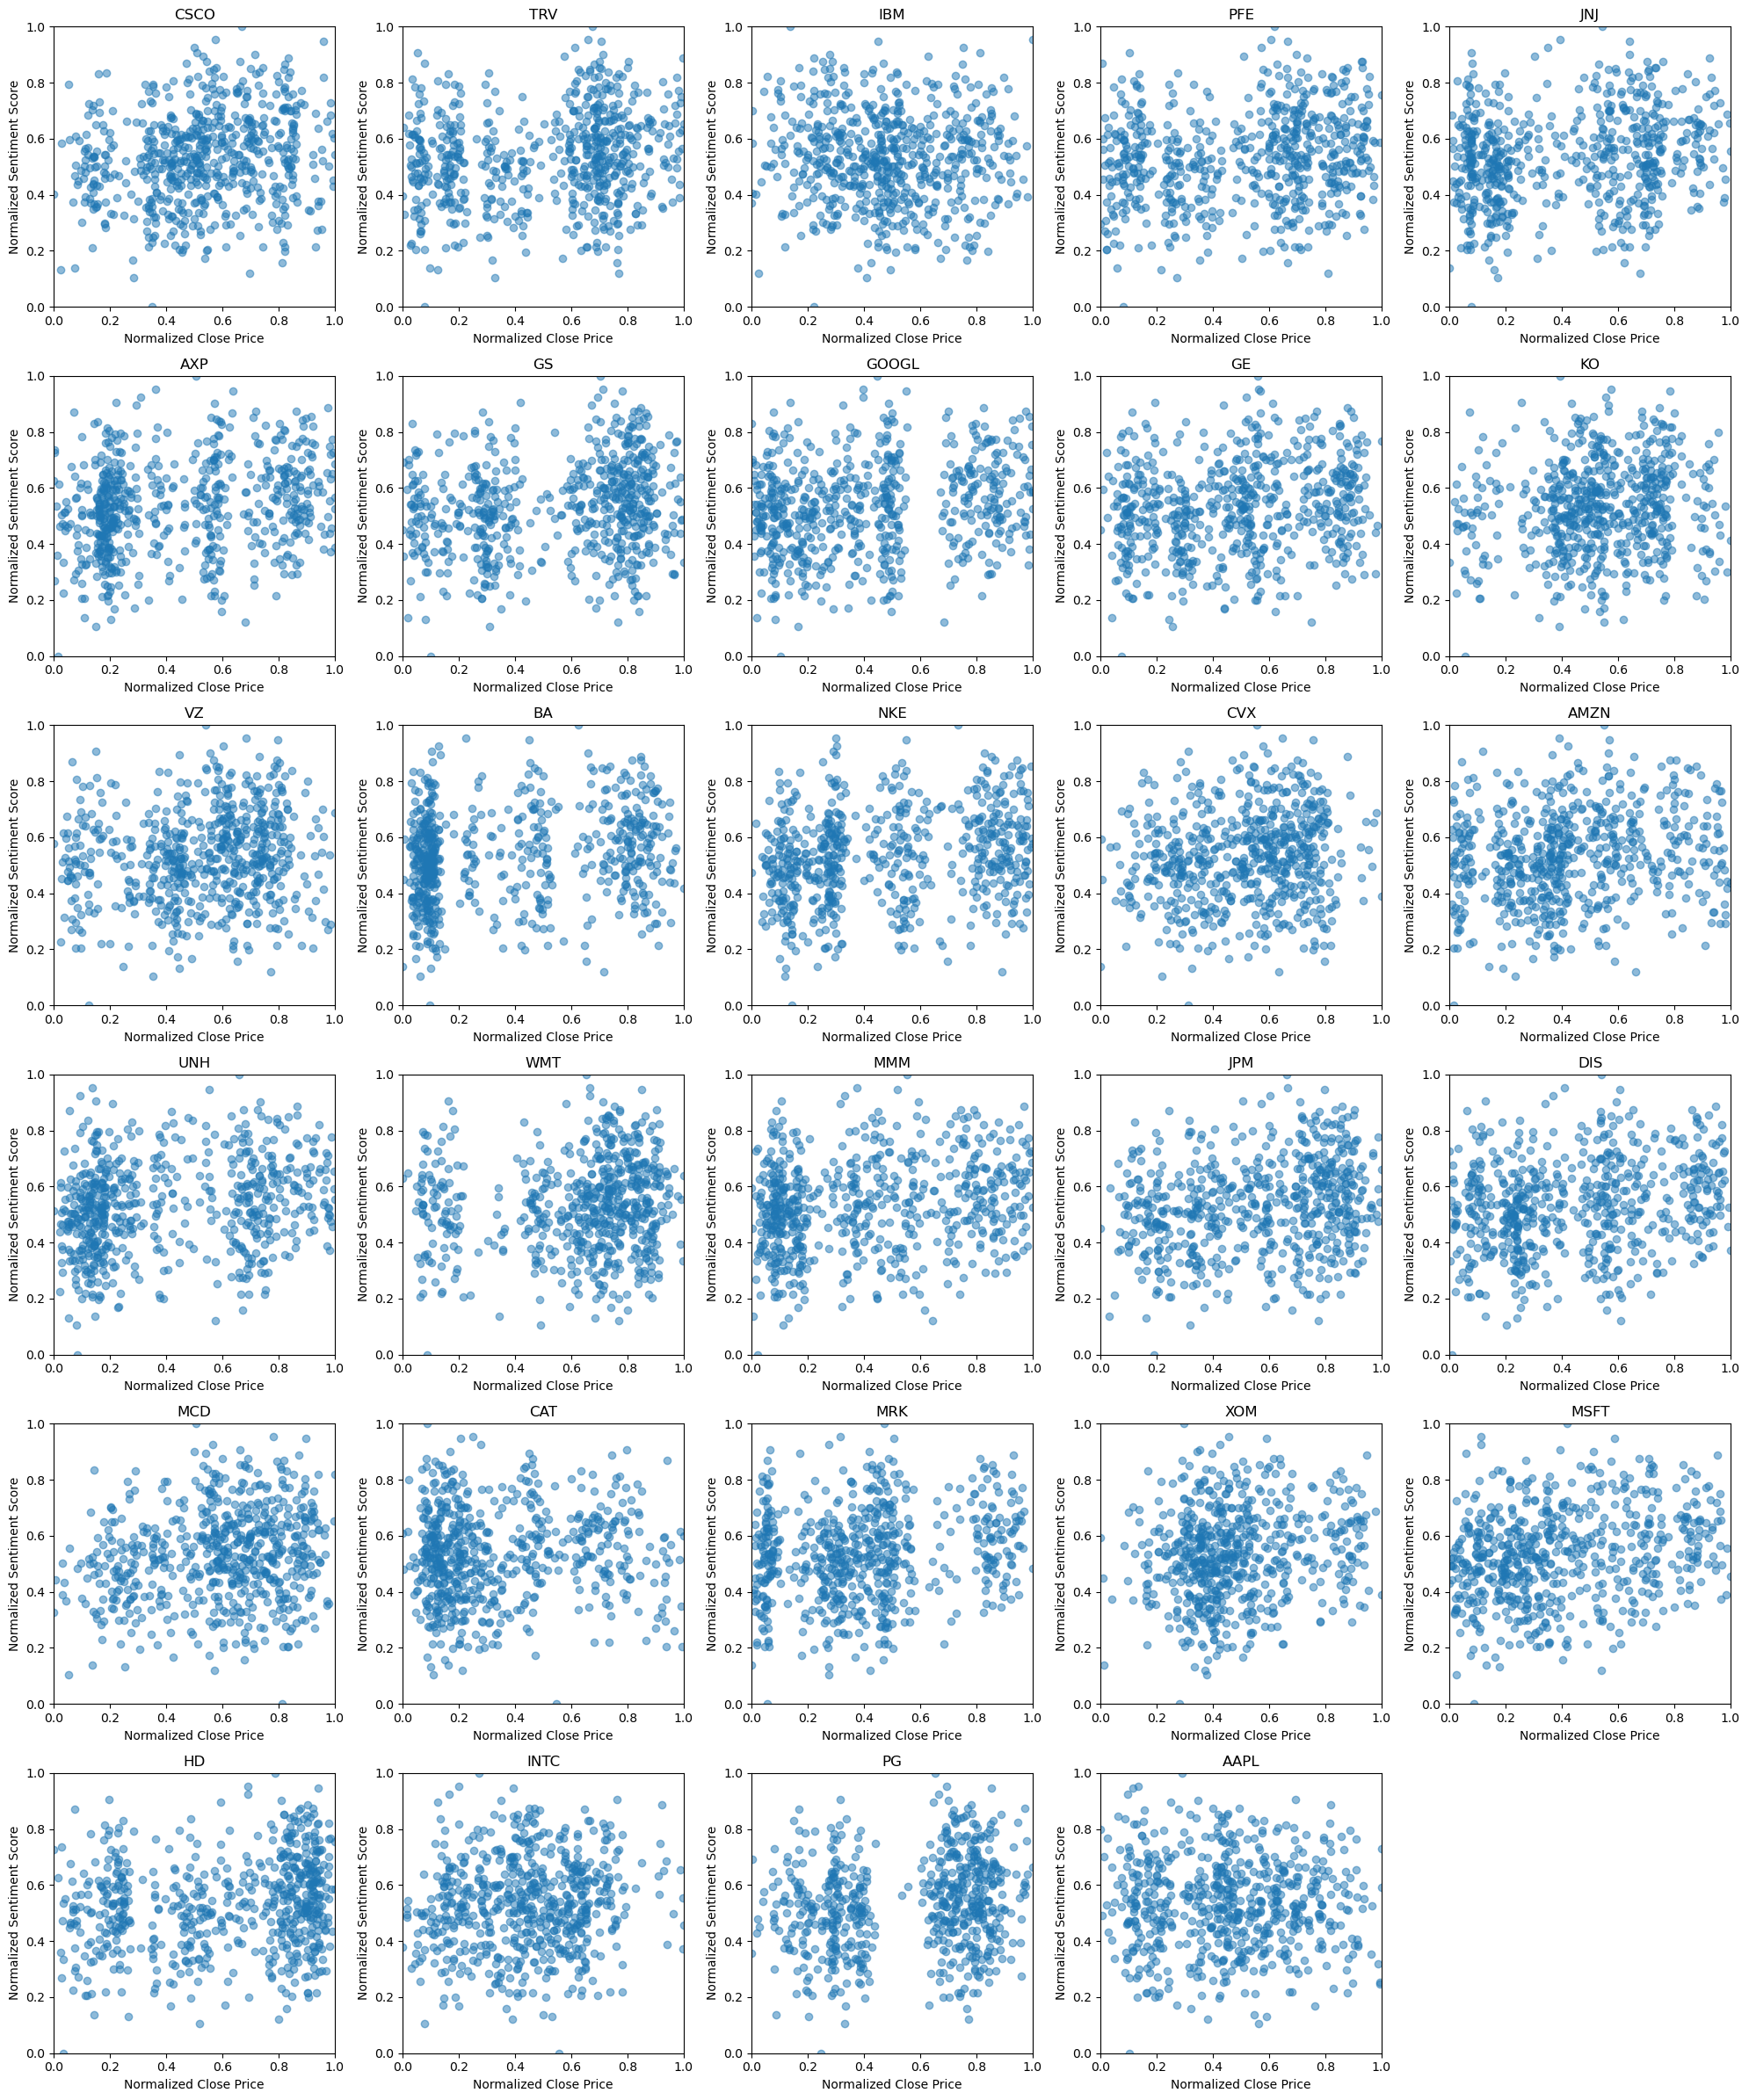

In [17]:
plot_scatter(features, tickers)

In [18]:
# Correlation matrix and edge creation
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in data.items()})
correlation_matrix = close_prices.corr()
print(correlation_matrix)
correlation_threshold = 0.5
edges = []
num_nodes = len(tickers)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            edges.append((i, j))
            edges.append((j, i))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


           CSCO       TRV       IBM       PFE       JNJ       AXP        GS  \
CSCO   1.000000  0.753532 -0.214252  0.698086  0.801310  0.725163  0.854623   
TRV    0.753532  1.000000 -0.326865  0.939359  0.937928  0.872568  0.910345   
IBM   -0.214252 -0.326865  1.000000 -0.365430 -0.461445 -0.492341 -0.313952   
PFE    0.698086  0.939359 -0.365430  1.000000  0.920057  0.890285  0.913680   
JNJ    0.801310  0.937928 -0.461445  0.920057  1.000000  0.956993  0.900277   
AXP    0.725163  0.872568 -0.492341  0.890285  0.956993  1.000000  0.872512   
GS     0.854623  0.910345 -0.313952  0.913680  0.900277  0.872512  1.000000   
GOOGL  0.699497  0.870016 -0.491904  0.917046  0.933904  0.969856  0.887439   
GE     0.704631  0.926598 -0.418711  0.927279  0.941692  0.931726  0.899683   
KO     0.472152  0.743079  0.014186  0.677999  0.678136  0.620087  0.559432   
VZ     0.608277  0.864950 -0.170356  0.842579  0.794673  0.706920  0.733235   
BA     0.706860  0.833707 -0.607703  0.854680  0.934

In [19]:
torch.tensor(edges, dtype=torch.long)

tensor([[ 0,  1],
        [ 1,  0],
        [ 0,  3],
        ...,
        [27, 24],
        [25, 27],
        [27, 25]])

In [20]:
torch.tensor(edges, dtype=torch.long).t()

tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]])

In [21]:
torch.tensor(edges, dtype=torch.long).t().contiguous()

tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]])

In [22]:
num_edges = edge_index.shape[1]
print("Number of edges:", num_edges)

Number of edges: 572


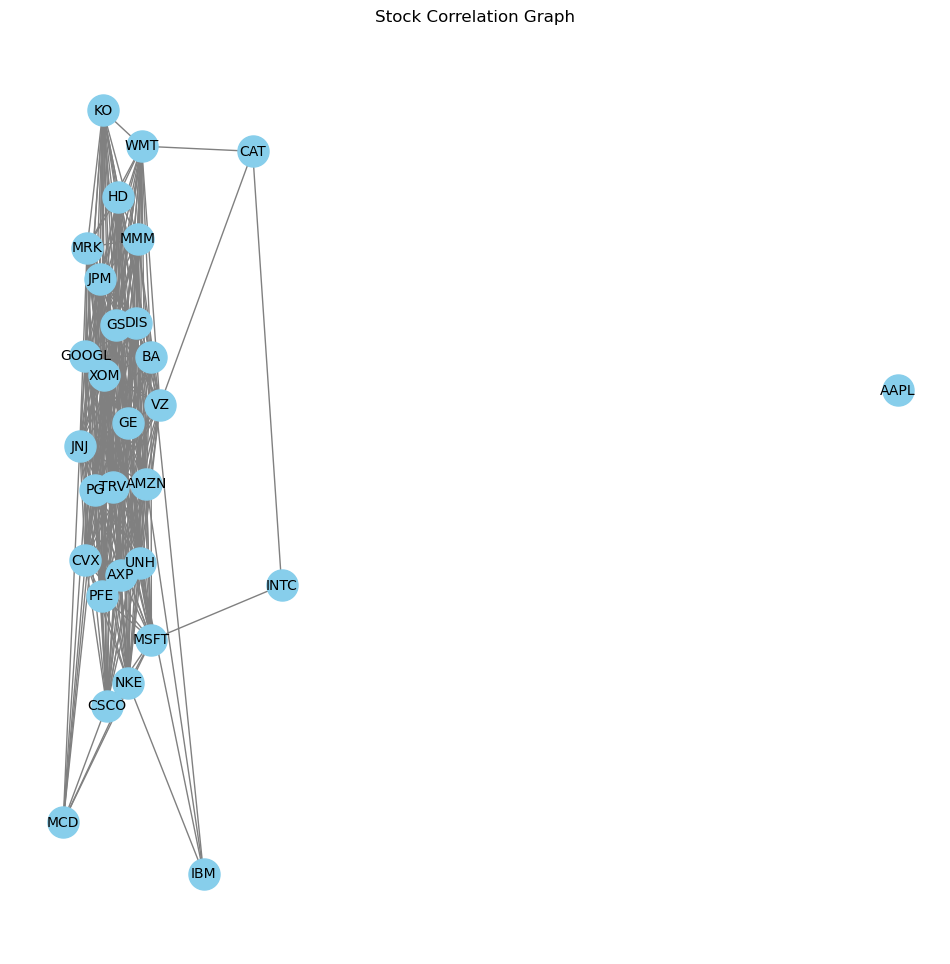

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
for ticker in tickers:
    G.add_node(ticker)

# Add edges based on the correlation matrix
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            G.add_edge(tickers[i], tickers[j])

# Draw the graph
plt.figure(figsize=(12, 12))  # Set the figure size
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Stock Correlation Graph")
plt.axis('off')  # Turn off the axis
plt.show()


In [24]:
import torch
from torch_geometric.data import Data

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the features NumPy array to a PyTorch tensor
# The shape of features is (29, 626, 2)
x = torch.tensor(features, dtype=torch.float).to(device)

# Convert the NumPy array of labels to a PyTorch tensor
# The shape of labels is (29, 626)
y = torch.tensor(labels, dtype=torch.long).to(device)


# to match the new size of the feature matrix. Ensure edge_index is on the same device
edge_index = edge_index.to(device)

# Create the Data object with features, edge index, and labels
# The shape of 'x' and 'y' tensors should be compatible with model's architecture
graph_data = Data(x=x, edge_index=edge_index, y=y)

print(x, y, edge_index)
print(graph_data)


tensor([[[0.3117, 0.7253],
         [0.3437, 0.6272],
         [0.3375, 0.3612],
         ...,
         [0.8464, 0.6560],
         [0.8508, 0.4560],
         [0.8641, 0.3730]],

        [[0.0547, 0.7253],
         [0.0485, 0.6272],
         [0.0635, 0.3612],
         ...,
         [0.9693, 0.6560],
         [0.9566, 0.4560],
         [0.9605, 0.3730]],

        [[0.3140, 0.7253],
         [0.2963, 0.6272],
         [0.2758, 0.3612],
         ...,
         [0.1760, 0.6560],
         [0.2072, 0.4560],
         [0.1970, 0.3730]],

        ...,

        [[0.4477, 0.7253],
         [0.4970, 0.6272],
         [0.5220, 0.3612],
         ...,
         [0.9870, 0.6560],
         [1.0000, 0.4560],
         [0.9974, 0.3730]],

        [[0.2892, 0.7253],
         [0.2881, 0.6272],
         [0.2774, 0.3612],
         ...,
         [0.7402, 0.6560],
         [0.7555, 0.4560],
         [0.7391, 0.3730]],

        [[0.0664, 0.7253],
         [0.0735, 0.6272],
         [0.0883, 0.3612],
         ...,
 

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNLSTM(nn.Module):
    def __init__(self, num_features, gcn_hidden, lstm_hidden, num_classes, num_nodes):
        super(GCNLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.lstm_hidden = lstm_hidden  # Ensure this attribute is correctly set
        self.gcn = GCNConv(num_features, gcn_hidden)
        self.lstm = nn.LSTM(gcn_hidden, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x, edge_index):
        # Process each day for all stocks through GCN
        # Reshape x to (-1, num_features) to combine all days and nodes for GCN processing
        x = x.view(-1, x.size(-1))
        x = F.relu(self.gcn(x, edge_index))

        # Reshape back to original structure: (num_nodes, num_days, gcn_hidden)
        x = x.view(self.num_nodes, -1, x.size(-1))

        # Process each stock's time series through LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Reshape LSTM output for classification: (num_nodes * num_days, lstm_hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.lstm_hidden)

        # Classifier on the output of LSTM
        out = self.fc(lstm_out)

        return out




In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with the correct number of arguments
num_features = 2  # Number of features: normalized close price and sentiment score
gcn_hidden = 64   # Size of GCN hidden layer
lstm_hidden = 32  # Size of LSTM hidden layer
num_classes = 2   # Number of classes for prediction (e.g., up or down)
num_nodes = 29    # Number of stocks
num_days = 626    # Number of days

model = GCNLSTM(num_features, gcn_hidden, lstm_hidden, num_classes, num_nodes).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    
    # Move your data to the same device as your model
    x = x.to(device)
    edge_index = edge_index.to(device)
    y = y.to(device)

    # Forward pass for the entire graph
    out = model(x, edge_index)  # Assuming you have a single graph

    # Reshape output and labels to be compatible with CrossEntropyLoss
    out = out.view(num_nodes * num_days, num_classes)
    y = y.view(-1)

    # Compute loss on the entire graph
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.6925464868545532
Epoch 1, Loss: 0.6924823522567749
Epoch 2, Loss: 0.6924147009849548
Epoch 3, Loss: 0.692356526851654
Epoch 4, Loss: 0.6923002600669861
Epoch 5, Loss: 0.6922410726547241
Epoch 6, Loss: 0.6921846270561218
Epoch 7, Loss: 0.6921302676200867
Epoch 8, Loss: 0.6920729875564575
Epoch 9, Loss: 0.6920138597488403
Epoch 10, Loss: 0.6919543743133545
Epoch 11, Loss: 0.6918913125991821
Epoch 12, Loss: 0.6918228268623352
Epoch 13, Loss: 0.6917502284049988
Epoch 14, Loss: 0.6916723847389221
Epoch 15, Loss: 0.6915867924690247
Epoch 16, Loss: 0.6914936900138855
Epoch 17, Loss: 0.6913935542106628
Epoch 18, Loss: 0.6912844777107239
Epoch 19, Loss: 0.6911661028862
Epoch 20, Loss: 0.6910396814346313
Epoch 21, Loss: 0.6909042000770569
Epoch 22, Loss: 0.6907588839530945
Epoch 23, Loss: 0.6906054615974426
Epoch 24, Loss: 0.690443754196167
Epoch 25, Loss: 0.6902738809585571
Epoch 26, Loss: 0.6900951266288757
Epoch 27, Loss: 0.6899059414863586
Epoch 28, Loss: 0.689705491065979
E

In [27]:
# Prepare validation data 

In [28]:
start_date = '2014-07-01'
end_date = '2016-07-01'

filtered_sentiment_data_val = sentiment_by_date[(sentiment_by_date['Date'] >= start_date) & (sentiment_by_date['Date'] <= end_date)]


In [29]:
# Downloading stock data
tickers_val = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']
data_val = {ticker_val: yf.download(ticker_val, start="2014-07-01", end="2016-07-01") for ticker_val in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [30]:
import numpy as np
import pandas as pd

# Convert Date to string for easy mapping in sentiment data
filtered_sentiment_data_val['Date'] = pd.to_datetime(filtered_sentiment_data_val['Date']).dt.strftime('%Y-%m-%d')

# Create a dictionary for sentiment data for fast lookup
sentiment_dict_val = dict(zip(filtered_sentiment_data_val['Date'], filtered_sentiment_data_val['sentiment_score']))

# Preprocessing
features_val = []
labels_val = []
for ticker_val, df_val in data_val.items():
    # Normalize close prices
    normalized_close = (df_val['Close'] - df_val['Close'].min()) / (df_val['Close'].max() - df_val['Close'].min())

    # Map sentiment scores to the stock data dates
    df_val_index_as_str = df_val.index.strftime('%Y-%m-%d')
    df_val['Sentiment'] = df_val_index_as_str.map(sentiment_dict_val)

    # Handle missing sentiment values (if any)
    df_val['Sentiment'].fillna(0, inplace=True)

    # Normalize sentiment scores (optional, depending on your use case)
    normalized_sentiment = (df_val['Sentiment'] - df_val['Sentiment'].min()) / (df_val['Sentiment'].max() - df_val['Sentiment'].min())

    # Combine normalized close prices and sentiment scores
    combined_features = np.column_stack((normalized_close, normalized_sentiment))

    # Append to features list
    features_val.append(combined_features)

    # Generate labels (1 if price increase, 0 otherwise)
    labels_val.append(df_val['Close'].diff().apply(lambda x: 1 if x > 0 else 0).values)

# Convert to numpy array
features_val = np.array(features_val)
labels_val = np.array(labels_val)

# Adjust labels - Shift labels by one day and remove the first label
adjusted_labels_val = np.array([label[1:] for label in labels_val])

# Adjust features - Remove the last day's features for each stock
adjusted_features_val = np.array([feature[:-1] for feature in features_val])

# Print shapes for verification
print("Shape of features:", adjusted_features_val.shape)
print("Shape of labels:", adjusted_labels_val.shape)


Shape of features: (29, 504, 2)
Shape of labels: (29, 504)


In [31]:
# Correlation matrix and edge creation
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in data.items()})
correlation_matrix = close_prices.corr()
print(correlation_matrix)
correlation_threshold = 0.5
edges = []
num_nodes = len(tickers)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            edges.append((i, j))
            edges.append((j, i))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

           CSCO       TRV       IBM       PFE       JNJ       AXP        GS  \
CSCO   1.000000  0.753532 -0.214252  0.698086  0.801310  0.725163  0.854623   
TRV    0.753532  1.000000 -0.326865  0.939359  0.937928  0.872568  0.910345   
IBM   -0.214252 -0.326865  1.000000 -0.365430 -0.461445 -0.492341 -0.313952   
PFE    0.698086  0.939359 -0.365430  1.000000  0.920057  0.890285  0.913680   
JNJ    0.801310  0.937928 -0.461445  0.920057  1.000000  0.956993  0.900277   
AXP    0.725163  0.872568 -0.492341  0.890285  0.956993  1.000000  0.872512   
GS     0.854623  0.910345 -0.313952  0.913680  0.900277  0.872512  1.000000   
GOOGL  0.699497  0.870016 -0.491904  0.917046  0.933904  0.969856  0.887439   
GE     0.704631  0.926598 -0.418711  0.927279  0.941692  0.931726  0.899683   
KO     0.472152  0.743079  0.014186  0.677999  0.678136  0.620087  0.559432   
VZ     0.608277  0.864950 -0.170356  0.842579  0.794673  0.706920  0.733235   
BA     0.706860  0.833707 -0.607703  0.854680  0.934

In [32]:
import torch
from torch_geometric.data import Data

# Convert the features NumPy array to a PyTorch tensor
x_val = torch.tensor(adjusted_features_val, dtype=torch.float).to(device)

# Convert the NumPy array of labels to a PyTorch tensor
y_val = torch.tensor(adjusted_labels_val, dtype=torch.long).to(device)  # Assuming last column for labels

edge_index = edge_index.to(device)

# Create the Data object with features, edge index, and labels
graph_data = Data(x_val=x_val, edge_index=edge_index, y_val=y_val)

print(x_val,y_val,edge_index)

print(graph_data)

tensor([[[0.3346, 0.4328],
         [0.3281, 0.1888],
         [0.3490, 0.6285],
         ...,
         [0.6250, 0.5309],
         [0.6875, 0.6936],
         [0.7487, 0.4696]],

        [[0.2035, 0.4328],
         [0.1838, 0.1888],
         [0.1912, 0.6285],
         ...,
         [0.7096, 0.5309],
         [0.8359, 0.6936],
         [0.9255, 0.4696]],

        [[0.8790, 0.4328],
         [0.9052, 0.1888],
         [0.9070, 0.6285],
         ...,
         [0.3291, 0.5309],
         [0.3574, 0.6936],
         [0.3928, 0.4696]],

        ...,

        [[0.4331, 0.4328],
         [0.4331, 0.1888],
         [0.4466, 0.6285],
         ...,
         [0.4110, 0.5309],
         [0.4508, 0.6936],
         [0.5136, 0.4696]],

        [[0.4417, 0.4328],
         [0.4528, 0.1888],
         [0.4693, 0.6285],
         ...,
         [0.5185, 0.5309],
         [0.5669, 0.6936],
         [0.6240, 0.4696]],

        [[0.0745, 0.4328],
         [0.0736, 0.1888],
         [0.0865, 0.6285],
         ...,
 

In [33]:
import torch
from torch_geometric.data import Data

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of nodes (stocks)
num_nodes_val = 29  # Adjust if different for validation set
num_days_val = adjusted_features_val.shape[1]  # Number of days in the validation set

# Convert the adjusted features NumPy array to a PyTorch tensor
x_val = torch.tensor(adjusted_features_val, dtype=torch.float).to(device)

# Convert the adjusted labels NumPy array to a PyTorch tensor
# Reshape the labels to a 1D tensor
y_val = torch.tensor(adjusted_labels_val, dtype=torch.long).view(-1).to(device)

# Assuming you already have the edge_index tensor and it's on the correct device
edge_index = edge_index.to(device)

# Create the Data object with features, edge index, and labels
graph_data_val = Data(x=x_val, edge_index=edge_index, y=y_val)

print(graph_data_val)


Data(x=[29, 504, 2], edge_index=[2, 572], y=[14616])


In [34]:
# Validation Phase
model.eval()
with torch.no_grad():
    # Move your validation data to the same device as your model
    x_val = x_val.to(device)
    edge_index = edge_index.to(device)
    y_val = y_val.to(device)

    # Forward pass for the validation data
    val_out = model(x_val, edge_index)

    # Reshape val_out to match the shape of y_val for loss calculation
    val_out = val_out.view(-1, num_classes)
    
    # Compute the validation loss
    val_loss = criterion(val_out, y_val)

    # Get the predicted class (with highest probability)
    _, val_pred = torch.max(val_out, dim=1)

    # Calculate accuracy
    val_correct = int(val_pred.eq(y_val).sum().item())
    val_accuracy = val_correct / y_val.size(0)

print(f'Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}')




Validation Loss: 1.131268858909607, Validation Accuracy: 0.48323754789272033


In [35]:
y_val.size(0)

14616

In [36]:
# Assuming out is the output of your model for multiple days for all stocks
# out should have a shape of (num_nodes * num_days, num_classes)

daily_aggregated_predictions = []
num_days=505

for day in range(num_days):
    # Get predictions for all stocks for this day
    daily_predictions = val_out[day * num_nodes: (day + 1) * num_nodes]

    # Convert these predictions to labels (0 or 1)
    daily_labels = torch.argmax(daily_predictions, dim=1)

    # Aggregate these labels using a majority vote
    # If the sum of daily labels is greater than half of num_nodes, the aggregated label is 1, else 0
    aggregated_label = 1 if torch.sum(daily_labels).item() > num_nodes / 2 else 0

    daily_aggregated_predictions.append(aggregated_label)

# daily_aggregated_predictions now contains the aggregated predicted label for each day


In [37]:
# Download DJIA data
djia = yf.download('^DJI', start="2014-07-01", end="2016-07-01")  # Replace dates as needed

# Create daily labels
# Label is 1 if the closing price is higher than the previous day, 0 otherwise
djia['Label'] = (djia['Close'] > djia['Close'].shift(1)).astype(int)

# Drop the first row as it won't have a label
djia = djia.dropna()

# Now djia['Label'] contains your daily labels
print(djia[['Close', 'Label']])


[*********************100%%**********************]  1 of 1 completed
                   Close  Label
Date                           
2014-07-01  16956.070312      0
2014-07-02  16976.240234      1
2014-07-03  17068.259766      1
2014-07-07  17024.210938      0
2014-07-08  16906.619141      0
...                  ...    ...
2016-06-24  17400.750000      0
2016-06-27  17140.240234      0
2016-06-28  17409.720703      1
2016-06-29  17694.679688      1
2016-06-30  17929.990234      1

[505 rows x 2 columns]


In [38]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming `daily_aggregated_predictions` is a list of your model's daily aggregated predictions
daily_predictions = daily_aggregated_predictions  # Replace with the list of aggregated predictions

# Assuming `djia` is your DataFrame with actual DJIA data
# Extract actual labels into a list
actual_djia_labels = djia['Label'].tolist()

# Calculate metrics for each day
daily_accuracy = accuracy_score(actual_djia_labels, daily_predictions)
daily_precision = precision_score(actual_djia_labels, daily_predictions)
daily_recall = recall_score(actual_djia_labels, daily_predictions)
daily_f1 = f1_score(actual_djia_labels, daily_predictions)
daily_conf_matrix = confusion_matrix(actual_djia_labels, daily_predictions)

print("Daily Accuracy:", daily_accuracy)
print("Daily Precision:", daily_precision)
print("Daily Recall:", daily_recall)
print("Daily F1 Score:", daily_f1)
print("Daily Confusion Matrix:\n", daily_conf_matrix)


Daily Accuracy: 0.5069306930693069
Daily Precision: 0.5256410256410257
Daily Recall: 0.47126436781609193
Daily F1 Score: 0.49696969696969695
Daily Confusion Matrix:
 [[133 111]
 [138 123]]


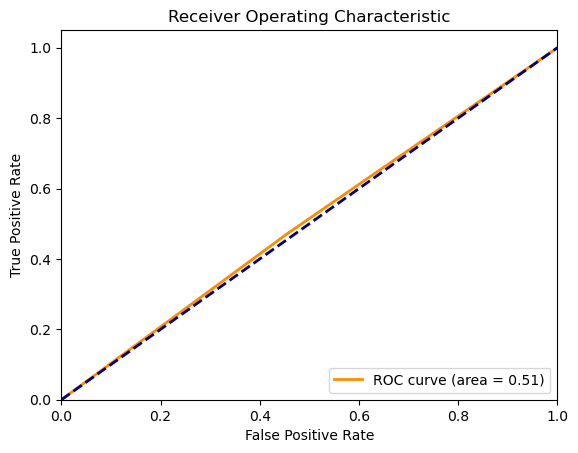

In [39]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `daily_aggregated_probabilities` contains the probability predictions of the positive class
daily_probabilities = daily_aggregated_predictions  # Replace with the list of probabilities

# Assuming `djia` is your DataFrame with actual DJIA data
actual_djia_labels = djia['Label'].tolist()  # Extract actual labels into a list

# Calculate ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(actual_djia_labels, daily_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
